## BeerAdvocate: Descriptive Analysis and Processing

---

**Processing and Transformations Summary of "users.csv"**

- **Renaming Columns**:     "beer_id" to "bid",
    "user_id" to "uid",
    "review" to "has_review",
    "text" to "review"
- **Converting Data Types**: 
    "bid" to np.int32,
    "uid" to "str",
    "has_review" to "bool"
- **Taking only the review of 4 contries of interest"**: "United States", "Canada", "England", "Australia" thus loosing 9% of the ratings

---

**Descriptive Analysis Summary of "users.csv"**

* **Missing values**: none, except for "location" that may contain "nan" (previously converted to None) and "joined" that may contain NaN (previously implictely converted to NaT).

<br>

* **ratings**:
  - 8'393'032 ratings in total.
  - The average of the ratings is 3.89 with a standard deviation of 0.61
  - Approximatly follow the distribution $\mathcal{N}(3.89,0.61^{2})\ $

* **reviews**:
  - 2'414'889 review in total
  - average number of char is $\approx$ 680
  - average number of word is $\approx$ 119
 


---



In [1]:
from setup import dask_init, dask_shutdown
import dask.distributed as dd
import dask.dataframe as ddf

import pandas as pd
import numpy as np

import ingestion as ing
import processing as prc

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# setup

In [2]:
# PANDAS SETUP
pd.options.mode.use_inf_as_na = True

# DASK SETUP
client, cluster = dask_init()
cluster

### BeerAdvocate - ratings.csv (REFINED ratings.txt)

# [I] Loading the Data

In [3]:
__RATINGS_COLS=[
    "date",
    "beer_id",
    "user_id",
    "appearance",
    "aroma",
    "palate",
    "taste",
    "overall",
    "rating",
    "review",
    "text"
]
ratings_ddf = ing.read_csv(
        path=ing.build_path(folderind="ba", filename="ratings", basepath=ing.REFINED_PATH),
        assume_missing=True,
        keepcols=__RATINGS_COLS,
        mode="lazy")

ratings_ddf.head(5)

,date,beer_id,user_id,appearance,aroma,palate,taste,overall,rating,review,text
0,1.440065e+09,142544.0,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,True,"From a bottle, pours a piss yellow color with ..."
1,1.235128e+09,19590.0,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,True,Pours pale copper with a thin head that quickl...
2,1.142248e+09,19590.0,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,True,"500ml Bottle bought from The Vintage, Antrim....."
3,1.101899e+09,19590.0,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,True,Serving: 500ml brown bottlePour: Good head wit...
4,1.093860e+09,19590.0,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,True,"500ml bottlePours with a light, slightly hazy ..."


In [4]:

print(len(ratings_ddf.index.compute()))
ratings_ddf.dtypes

8393032


date          float64
beer_id       float64
user_id        object
appearance    float64
aroma         float64
palate        float64
taste         float64
overall       float64
rating        float64
review           bool
text           object
dtype: object

# [II] Impact of Processing

In [5]:
__RATINGS_COLS_RENAMING = {
    "beer_id": "bid",
    "user_id": "uid",
    "review" : "has_review",
    "text" : "review"
}
ratings_ddf = ratings_ddf.rename(columns=__RATINGS_COLS_RENAMING)
new_rating_colnames = [__RATINGS_COLS_RENAMING.get(old_colname, old_colname) for old_colname in __RATINGS_COLS]
ratings_ddf = ratings_ddf[new_rating_colnames]

In [6]:
print("What's the number of ratings with unknown beers ?")

# drop beer ratings with missing beer ID since we do not know to which beer the rating corresponds
discarded= len(ratings_ddf[ratings_ddf.bid.isnull()].index)
print(discarded)


What's the number of ratings with unknown beers ?
0


In [7]:
print("What's the number of ratings with unknown users ?")

# drop beer ratings with missing beer ID since we do not know to which user the rating corresponds
discarded= len(ratings_ddf[ratings_ddf.uid.isnull()].index)
print(discarded)

What's the number of ratings with unknown users ?
0


In [8]:
print("What's the number of ratings with unknown score ?")

# keep only ratings with computable beer rating
# a beer rating is computable <=> all beer aspects' ratings are available
# if the beer rating is available, do not drop the rating
__RATING_ASPECTS = [
    "appearance", "aroma", "palate", "taste", "overall"]
computable_rating_mask = True # (False | X) == X
for rating_aspect in __RATING_ASPECTS:
    computable_rating_mask &= ratings_ddf[rating_aspect].notnull()
discarded = (~(computable_rating_mask | ratings_ddf.rating.notnull())).sum().compute()
print(discarded)


What's the number of ratings with unknown score ?
0


In [9]:
users_ddf = ing.read_parquet(
            path=ing.build_path(folderind="ba", filename="users", ext=".parquet", basepath=ing.REFINED_PATH),
            mode="lazy"
        )
users_w_ratings_ddf = ddf.merge(
        ratings_ddf,
        users_ddf, 
        how="inner", left_on="uid", right_on="uid")

ratings_ddf = ratings_ddf[new_rating_colnames] # drops the join columns

In [13]:
print('What\'s the percentage of ratings discarded when we select only ratings of users from the countries of interest?')
__COUNTRIES_OF_INTEREST = [
    "United States", "Canada", "England", "Australia"]
discarded=1-len(users_w_ratings_ddf[users_w_ratings_ddf.country.isin(__COUNTRIES_OF_INTEREST)].index)/len(users_w_ratings_ddf.index)
print("{}%".format(round(discarded*100, 2)))

What's the percentage of ratings discarded when we select only ratings of users from the countries of interest?
8.79%


# [III] Descriptive Statistics & Distributions

In [6]:
from processing import beers_pipeline, users_pipeline, ratings_pipeline
print("processing ratings")
ratings_pipeline(persist=True, users_persisted=True)
print("done! persisted in ./RefinedData/BeerAdvocate/ratings.parquet")

processing ratings


Downloading:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

  0%|          | 0/75466 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
ratings_ddf=ing.read_parquet('RefinedData\BeerAdvocate\\ratings.parquet')
ratings_ddf[['appearance','aroma','palate','taste','overall','rating']].describe().compute()

,appearance,aroma,palate,taste,overall,rating
count,4.406004e+06,4.406004e+06,4.406004e+06,4.406004e+06,4.406004e+06,7.654894e+06
mean,3.942058e+00,3.875325e+00,3.871813e+00,3.909083e+00,3.906254e+00,3.888538e+00
std,5.520657e-01,6.138992e-01,6.010812e-01,6.367106e-01,6.093449e-01,6.103158e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.000000e+00,3.750000e+00,3.750000e+00,3.750000e+00,3.750000e+00,3.750000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.060000e+00
75%,4.500000e+00,4.500000e+00,4.500000e+00,4.500000e+00,4.500000e+00,4.500000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


## rating

What's the distribution of the ratings ?


<AxesSubplot:title={'center':'Distribution of Ratings'}, xlabel='ratings', ylabel='occurences'>

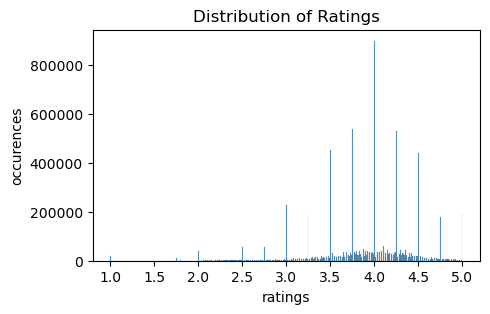

In [15]:
print('What\'s the distribution of the ratings ?')

fig, ax = plt.subplots(1,1)

# set the figure size
fig.set_size_inches(5, 3)

# set the title
ax.set_title("Distribution of Ratings")

# set the x and y labels
ax.set_ylabel("occurences")
ax.set_xlabel("ratings")

# plot the histogram
sns.histplot(data=ratings_ddf,x='rating',ax=ax)

Because the ratings are computed either from the unique note of the user or the average of the diffrent aspects for ratings we can see that the distribution has spikes when ratings is a multiple of 0.25.
If we isolate the effect we get the following graphs that show a normal distribution.

<AxesSubplot:title={'center':'Distribution of Ratings'}, xlabel='ratings', ylabel='occurences'>

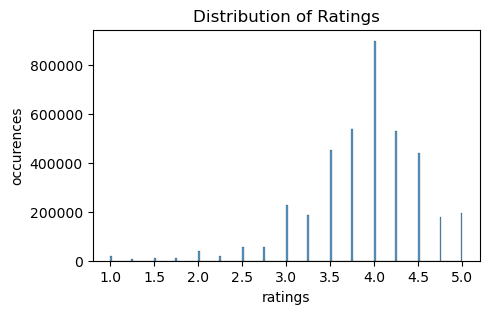

In [16]:
#isolatings 
fig, ax = plt.subplots(1,1)

# set figure size
fig.set_size_inches(5, 3)

# set title
ax.set_title("Distribution of Ratings")

# set x and y label
ax.set_ylabel("occurences")
ax.set_xlabel("ratings")

# plot the histogram
sns.histplot(data=ratings_ddf[ratings_ddf['rating']%0.25==0],x='rating',ax=ax,bins=200)

<AxesSubplot:title={'center':'Distribution of the number of ratings per beer'}, xlabel='ratings', ylabel='occurences'>

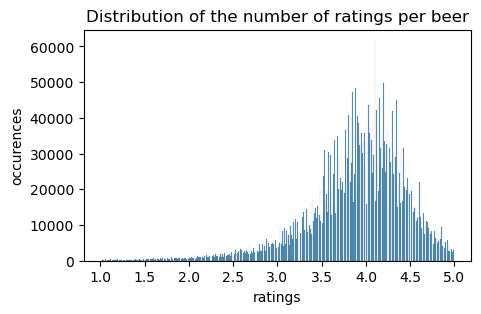

In [18]:
# set the figure size
plt.figure(figsize=(5, 3))

# set x and y axis labels
plt.xlabel("ratings")
plt.ylabel("occurences")

# set the title
plt.title("Distribution of the number of ratings per beer")
sns.histplot(data=ratings_ddf[ratings_ddf['rating']%0.25!=0],x='rating',bins=500)

## review

In [18]:
print('What percentage of ratings have a review ?')
print("{}%".format(round(len(ratings_ddf[ratings_ddf.has_review==True].index)/len(ratings_ddf.index)*100, 2)))

What percentage of ratings have a review ?
31.55%


In [19]:
print('What\'s the number of review ?')
ratings_ddf[ratings_ddf["has_review"]].compute()['review'].size

What's the number of review ?


2414889

In [20]:
print('What\'s the average number of characters per review ?')
ratings_ddf[ratings_ddf["has_review"]].compute()['review'].astype(str).map(lambda x: len(x)).mean()


What's the average number of characters per review ?


679.763346058556

In [21]:
print('What\'s the average number of word of a review ?')
ratings_ddf[ratings_ddf["has_review"]].compute()['review'].astype(str).map(lambda x: len(x.split())).mean()

What's the average number of word of a review ?


118.81396370599228